In [1]:
import cv2
import os

def prepare_data(hr_dir, lr_dir, scale_factor):
    hr_images = os.listdir(hr_dir)
    
    if not os.path.exists(lr_dir):
        os.makedirs(lr_dir)

    for image_name in hr_images:
        # Read the high-resolution image
        img = cv2.imread(os.path.join(hr_dir, image_name))
        
        # Downscale the image to create the low-resolution version
        lr_img = cv2.resize(img, (img.shape[1] // scale_factor, img.shape[0] // scale_factor))
        
        # Upscale the low-resolution image back to the original size
        lr_img = cv2.resize(lr_img, (img.shape[1], img.shape[0]))
        
        # Save the low-resolution image
        cv2.imwrite(os.path.join(lr_dir, image_name), lr_img)


hr_dir = 'data/pic/'
lr_dir = 'data/lr_pic/'
prepare_data(hr_dir, lr_dir, scale_factor=4)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)


In [3]:
# load pretrained models
load_pretrained_models = False
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 224
# high res. image width
hr_width = 224
# number of image channels
channels = 3

os.makedirs("out", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hr_shape = (hr_height, hr_width)

In [4]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("saved_models/generator.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

c:\anaconda3\envs\gan\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\anaconda3\envs\gan\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, hr_transform=None, lr_transform=None):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.hr_transform = hr_transform
        self.lr_transform = lr_transform
        self.hr_images = os.listdir(hr_dir)
        self.lr_images = os.listdir(lr_dir)

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_img = Image.open(os.path.join(self.hr_dir, self.hr_images[idx])).convert("RGB")
        lr_img = Image.open(os.path.join(self.lr_dir, self.lr_images[idx])).convert("RGB")
        if self.hr_transform:
            hr_img = self.hr_transform(hr_img)
        if self.lr_transform:
            lr_img = self.lr_transform(lr_img)
        return lr_img, hr_img

# Define transforms
hr_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((hr_height,hr_width))
])
lr_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((hr_height//4,hr_width//4))
])

# Load data
dataset = ImageDataset(hr_dir='data/pic/', lr_dir='data/lr_pic/', hr_transform=hr_transform, lr_transform=lr_transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    for i, (lr_imgs, hr_imgs) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((lr_imgs.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((lr_imgs.size(0), *discriminator.output_shape))), requires_grad=False)

        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()

        gen_hr = generator(lr_imgs)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(hr_imgs)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(hr_imgs), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Loss D: {loss_D.item()}, loss G: {loss_G.item()}")

    # Save models
    if (epoch+1) % 10 == 0:
        torch.save(generator.state_dict(), f"saved_models/generator_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"saved_models/discriminator_{epoch}.pth")


C:\Users\zht\AppData\Local\Temp\ipykernel_40456\1119650139.py:48: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:80.)
  valid = Variable(Tensor(np.ones((lr_imgs.size(0), *discriminator.output_shape))), requires_grad=False)


Epoch [0/1000] Loss D: 0.5165409445762634, loss G: 1.6108782291412354
Epoch [1/1000] Loss D: 0.28531742095947266, loss G: 1.3814349174499512
Epoch [2/1000] Loss D: 0.20554614067077637, loss G: 1.4015426635742188
Epoch [3/1000] Loss D: 0.16468167304992676, loss G: 1.3866198062896729
Epoch [4/1000] Loss D: 0.128526970744133, loss G: 1.350189447402954
Epoch [5/1000] Loss D: 0.09714244306087494, loss G: 1.2894599437713623
Epoch [6/1000] Loss D: 0.04809601604938507, loss G: 1.332058072090149
Epoch [7/1000] Loss D: 0.05300460755825043, loss G: 1.3652725219726562
Epoch [8/1000] Loss D: 0.03601520135998726, loss G: 1.3741487264633179
Epoch [9/1000] Loss D: 0.039921946823596954, loss G: 1.237282156944275
Epoch [10/1000] Loss D: 0.0374290905892849, loss G: 1.213781476020813
Epoch [11/1000] Loss D: 0.03304664045572281, loss G: 1.4590359926223755
Epoch [12/1000] Loss D: 0.03306010738015175, loss G: 1.3384796380996704
Epoch [13/1000] Loss D: 0.018477289006114006, loss G: 1.2401005029678345
Epoch [1

C:\Users\zht\AppData\Local\Temp\ipykernel_40456\2216241474.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('saved_models/generator_

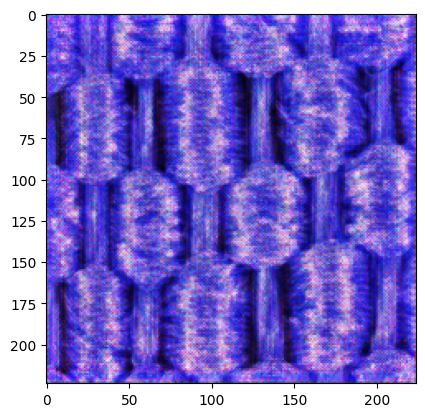

In [16]:
def upscale_image(lr_image, generator):
    generator.eval()
    lr_image = lr_transform(lr_image).unsqueeze(0).cuda()
    with torch.no_grad():
        sr_image = generator(lr_image).cpu().data
    sr_image = (sr_image + 1) / 2
    sr_image = np.transpose(sr_image.numpy(), (0, 2, 3, 1))
    return sr_image[0]

generator.load_state_dict(torch.load('saved_models/generator_999.pth'))
lr_img = Image.open('data/pic/29a6e4.png').convert("RGB")
sr_img = upscale_image(lr_img, generator)
plt.imshow(sr_img)
plt.show()
sr_img_pil = Image.fromarray((sr_img * 255).astype(np.uint8))
sr_img_pil.save('sample/002.png')


In [18]:
import os
from PIL import Image

def upscale_image(lr_image, generator):
    generator.eval()
    lr_image = lr_transform(lr_image).unsqueeze(0).cuda()
    with torch.no_grad():
        sr_image = generator(lr_image).cpu().data
    sr_image = (sr_image + 1) / 2
    sr_image = np.transpose(sr_image.numpy(), (0, 2, 3, 1))
    return sr_image[0]

generator.load_state_dict(torch.load('saved_models/generator_999.pth'))

# 定义输入文件夹路径和输出文件夹路径
input_folder = 'data/pic'
output_folder = 'data/augmented_img'

# 创建输出文件夹（如果不存在）
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 遍历输入文件夹中的所有图片
for filename in os.listdir(input_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')):  # 过滤图片格式
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path).convert("RGB")
        
        sr_img = upscale_image(img, generator)
        sr_img_pil = Image.fromarray((sr_img * 255).astype(np.uint8))
        
        # 获取文件名和扩展名
        base_name, ext = os.path.splitext(filename)
        
        # 创建新的文件名，添加 "_90" 后缀
        new_filename = f"{base_name}_aug{ext}"
        output_path = os.path.join(output_folder, new_filename)
        
        # 保存旋转后的图像到输出文件夹
        sr_img_pil.save(output_path)
        
        print(f"Saved augmented image: {output_path}")

print("All images have been augmented, saved, and original images are retained.")


C:\Users\zht\AppData\Local\Temp\ipykernel_40456\2832367286.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('saved_models/generator_

Saved augmented image: data/augmented_img\10a7e3_aug.png
Saved augmented image: data/augmented_img\10a7e3_90_aug.png
Saved augmented image: data/augmented_img\11a7e3_aug.png
Saved augmented image: data/augmented_img\11a7e3_90_aug.png
Saved augmented image: data/augmented_img\12a18e8_aug.png
Saved augmented image: data/augmented_img\12a18e8_90_aug.png
Saved augmented image: data/augmented_img\13a11e6_aug.png
Saved augmented image: data/augmented_img\13a11e6_90_aug.png
Saved augmented image: data/augmented_img\14a15e5_aug.png
Saved augmented image: data/augmented_img\14a15e5_90_aug.png
Saved augmented image: data/augmented_img\15a13e5_aug.png
Saved augmented image: data/augmented_img\15a13e5_90_aug.png
Saved augmented image: data/augmented_img\16a13e4_aug.png
Saved augmented image: data/augmented_img\16a13e4_90_aug.png
Saved augmented image: data/augmented_img\17a16e4_aug.png
Saved augmented image: data/augmented_img\17a16e4_90_aug.png
Saved augmented image: data/augmented_img\18a15e3_au

: 